**References** <br>
Detecting landmarks: [dev.to](https://dev.to/livecodestream/detecting-face-features-with-python-16o6) <br>
Cropping polygon: [stackoverflow](https://stackoverflow.com/questions/22588074/polygon-crop-clip-using-python-pil) <br>
Connecting to GCS: [ostrokach.gitlab.io](https://ostrokach.gitlab.io/post/google-colab-storage/#accessing-data-from-google-cloud-storage-gcs) <br>
Plaing image on top of another: [stackoverflow](https://stackoverflow.com/questions/2563822/how-do-you-composite-an-image-onto-another-image-with-pil-in-python/19678543)<br>



![Features Map](https://res.cloudinary.com/practicaldev/image/fetch/s--f_nLSOki--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/http://livecodestream.dev/post/2020-07-03-detecting-face-features-with-python/points.png)

## **Environment Setup**
Run all when initiating session

In [2]:
# retrieve config file, if using colab (nothing should happen if you use Windows)
!mkdir utils
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/dataset_engineering/utils/' '.'
!cp './drive/My Drive/Live Workspace/generative-facial-cosmetics/dataset_engineering/config.py' '.'

A subdirectory or file utils already exists.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
from config import *                            # config.py
from matplotlib import pyplot as plt 
import os
%matplotlib inline

## **GCS Integration**
Run all when initiating session

In [5]:
if isWindows():
  import utils.gcs_windows as gcs 
elif isColab():
  import utils.gcs_colab as gcs
else:
  raise NotImplementedError('OS is not supported yet')

gcs.init()

BUCKET1 = gcs.mount_bucket("ffhq-1024-us-east")
BUCKET2 = gcs.mount_bucket("ffhq-1024-lips-1")

Enter this command to your terminal and type in the volume of the mount:
rclone mount remote:ffhq-1024-us-east <VOL>: --vfs-cache-mode writes
Enter this command to your terminal and type in the volume of the mount:
rclone mount remote:ffhq-1024-lips-1 <VOL>: --vfs-cache-mode writes


''

## **Landmark Detection and Cropping**
Just imports and examples

In [ ]:
from utils.face_utils import *

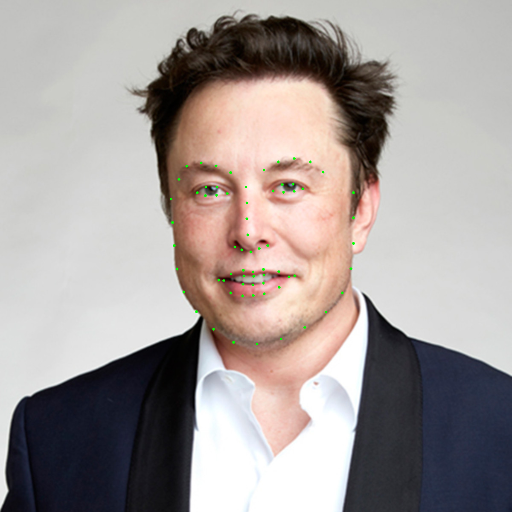

In [52]:
### example

IMGPATH = os.path.join(DIR, os.path.join("samples", "musk.jpg"))

landmarks_obj, _ = detect_landmarks(img_path=IMGPATH, show=True)

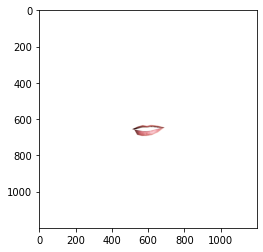

In [20]:
lips_img = detect_and_crop_lips(img_path=IMGPATH, show=True)

## **TF Setup and Dataset Importing**
Just imports

In [32]:
from utils.tfrecords import *

## **Side Task: Find Optimal Resizing**

In [1]:
import json
import os
import numpy as np
import time

In [37]:
def isAnomaly(img_data):
  if img_data['lips_w_r'] >= 1 or img_data['lips_h_r'] >= 1:
    return 1        # big lips
  if img_data['face_w'] <= 160:
    return 2        # small face
  return 0

### **Execution: Generate distribution details (one-time)**

In [22]:
filenames = get_tfrec_names(DATA_PATH)
dataset_raw = load_dataset(filenames, raw=True, shuffle=True)

In [ ]:
sum_w = 0
sum_h = 0
sum_w_r = 0
sum_h_r = 0
max_lips_w = 0
max_lips_h = 0
max_face_w = 0
max_face_h = 0
max_lips_w_r = 0
max_lips_h_r = 0
max_face_dif_r = 0
cnt = 0
idx = -1
alldict = dict()
start_time = time.time()
for image in dataset_raw:
  idx += 1
  landmarks_obj, face = detect_landmarks(img_bytes=image.numpy())         # don't forget to .numpy() on tf data
  if landmarks_obj == None: # no face detected, skip
    tf.io.write_file(DIR + 'anomalies/noface/' + str(idx) + '.png',image.numpy())
    continue
  cnt += 1
  face_w = np.abs(face.right() - face.left())
  face_h = np.abs(face.top() - face.bottom())
  lips_x = list(landmarks_obj.part(n).x for n in range(48, 68))
  lips_y = list(landmarks_obj.part(n).y for n in range(48, 68))
  min_x = np.min(lips_x)
  max_x = np.max(lips_x)
  min_y = np.min(lips_y)
  max_y = np.max(lips_y)
  lips_w = np.abs(max_x - min_x)
  lips_h = np.abs(max_y - min_y)
  lips_w_r = lips_w/face_w
  lips_h_r = lips_h/face_h

  img_data = dict()
  img_data['face_w'] = float(face_w)
  img_data['face_h'] = float(face_h)
  img_data['lips_w'] = float(lips_w)
  img_data['lips_h'] = float(lips_h)
  img_data['lips_w_r'] = float(lips_w_r)
  img_data['lips_h_r'] = float(lips_h_r)
  alldict[name] = img_data

  if isAnomaly(img_data) == 1:
    print('BigLips detected!')
    tf.io.write_file(DIR + 'anomalies/biglips/' + str(idx) + '.png',image.numpy())
  elif isAnomaly(img_data) == 2:
    print('SmallFace detected!')
    tf.io.write_file(DIR + 'anomalies/smallface/' + str(idx) + '.png',image.numpy())

  sum_w += lips_w
  sum_h += lips_h
  sum_w_r += lips_w_r
  sum_h_r += lips_h_r

  if lips_w > max_lips_w:
    max_lips_w = lips_w
  if lips_h > max_lips_h:
    max_lips_h = lips_h
  if face_w > max_face_w:
    max_face_w = face_w
  if face_h > max_face_h:
    max_face_h = face_h
  if lips_w_r > max_lips_w_r:
    max_lips_w_r = lips_w_r
  if lips_h_r > max_lips_h_r:
    max_lips_h_r = lips_h_r
  if np.max([face_w, face_h])/np.min([face_w, face_h]) > max_face_dif_r:
    max_face_dif_r = np.max([face_w, face_h])/np.min([face_w, face_h])
  
  if cnt <= 10 or cnt % 100 == 0:
    with open(os.path.join(DIR, 'face_data.json'), 'w', encoding='UTF-8') as jsonoutput:
        json.dump(alldict, jsonoutput)
    print("---------------------- " + str(cnt) + " ----------------------")
    print("Time (seconds): " + str(time.time() - start_time))
    print("Average size in pixels = (" + str(sum_w/cnt) + ", " + str(sum_h/cnt) + ")")
    print("Average size in comparison to face size = (" + str(sum_w_r/cnt) + ", " + str(sum_h_r/cnt) + ")")
    print("Max lips size = (" + str(max_lips_w) + ", " + str(max_lips_h) + ")")
    print("Max lips size i.c.t.f.s = (" + str(max_lips_w_r) + ", " + str(max_lips_h_r) + ")")
    print("Max face size = (" + str(max_face_w) + ", " + str(max_face_h) + ")")
    print("Max face dim dif (times) = " + str(max_face_dif_r))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


---------------------- 1 ----------------------
Time (seconds): 27.266242027282715
Average size in pixels = (221.0, 50.0)
Average size in comparison to face size = (0.4130841121495327, 0.09345794392523364)
Max lips size = (221, 50)
Max lips size i.c.t.f.s = (0.4130841121495327, 0.09345794392523364)
Max face size = (535, 535)
Max face dim dif (times) = 1.0
---------------------- 2 ----------------------
Time (seconds): 28.82987356185913
Average size in pixels = (255.0, 76.5)
Average size in comparison to face size = (0.4316199376947041, 0.12694704049844235)
Max lips size = (289, 103)
Max lips size i.c.t.f.s = (0.4501557632398754, 0.16043613707165108)
Max face size = (642, 642)
Max face dim dif (times) = 1.0
---------------------- 3 ----------------------
Time (seconds): 30.510437488555908
Average size in pixels = (262.6666666666667, 114.66666666666667)
Average size in comparison to face size = (0.4320872274143302, 0.1838006230529595)
Max lips size = (289, 191)
Max lips size i.c.t.f.s = 

### **Execution: Analyze distribution details**

---------------------- 27000 ----------------------<br>
Time (seconds): 43011.175305366516<br>
Average size in pixels = (230.72637037037038, 92.18996296296297)<br>
Average size in comparison to face size = (0.39015518090343315, 0.1556693532386475)<br>
Max lips size = (350, 247)<br>
Max lips size i.c.t.f.s = (0.6467289719626168, 0.4616822429906542)<br>
Max face size = (770, 771)<br>
Max face dim dif (times) = 1.0012987012987014<br>

In [5]:
import pandas as pd
import json
import numpy as np
import os

In [6]:
f = open(os.path.join(DIR, 'face_data.json'), 'r', encoding='utf-8')
df = pd.read_json(f.read()).transpose()
f.close()

In [7]:
df      #Warning, numbers are not file name since some are skipped

,face_w,face_h,lips_w,lips_h,lips_w_r,lips_h_r
1,535.0,535.0,221.0,50.0,0.413084,0.093458
2,642.0,642.0,289.0,103.0,0.450156,0.160436
3,642.0,642.0,278.0,191.0,0.433022,0.297508
4,642.0,642.0,171.0,80.0,0.266355,0.124611
5,535.0,535.0,222.0,59.0,0.414953,0.110280
...,...,...,...,...,...,...
27096,642.0,642.0,225.0,58.0,0.350467,0.090343
27097,642.0,642.0,255.0,115.0,0.397196,0.179128
27098,535.0,535.0,262.0,132.0,0.489720,0.246729
27099,642.0,642.0,238.0,80.0,0.370717,0.124611


In [24]:
# how many unique face width?
set(df['face_h'])

{72.0, 446.0, 535.0, 642.0, 770.0, 771.0}

In [17]:
df[df['face_w'] == 72.0]

,face_w,face_h,lips_w,lips_h,lips_w_r,lips_h_r
8076,72.0,72.0,21.0,9.0,0.291667,0.125


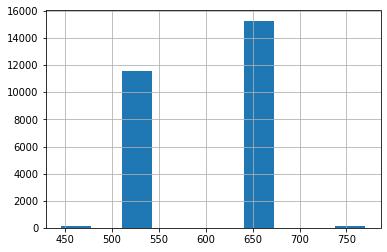

In [32]:
df['face_w'][df['face_w'].between(400, 800)].hist()

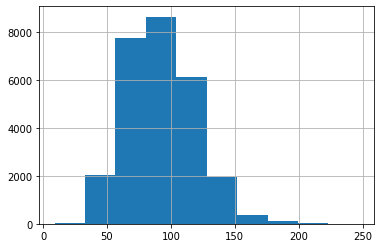

In [41]:
df['lips_h'].hist()

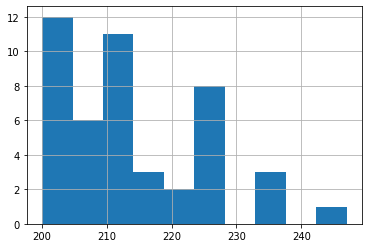

In [44]:
df['lips_h'][df['lips_h'].between(200, 250)].hist()

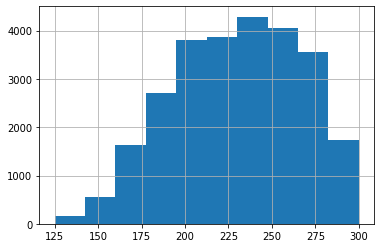

In [51]:
df['lips_w'][df['face_w'].between(535, 642)][df['lips_w'].between(125, 300)].hist()

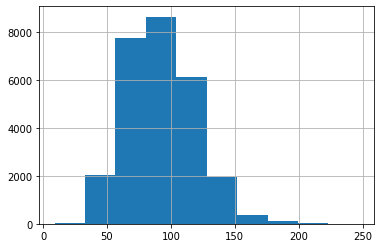

In [48]:
df['lips_h'].hist()

- Anomalous images are neglectible <br>
- Face width must be above **400** to not be anomalous
- Face width boundary for 1) should be **642**
- Face width middle for 2),3? should be **596**
- Face width upper for 4? should be **642**
- Lips size boundary for 1),2) should be **305, 305** 
- Lips width middle for 3) should be **230** (true border's height will be max of these, **or just square it**)
- Lips width upper for 4) should be **305** (true border's height will be max of these, **or just square it**)
<br><br>
- These do not include padding



## **Crop Lips from the Dataset**

In [118]:
import io

SHARD_SIZE = 128

### **Execution**

In [140]:
filenames = get_tfrec_names(DATA_PATH)
dataset_raw = load_dataset(filenames, raw=True, shuffle=False)

In [ ]:
'''
1)
  Naive: Detect Face (N*N) --> chk (1) --> Detect Lips (N*N) --> chk (1) --> Filter (N*N) --> Crop (k) 
  Optimized: N/A
2)
  Naive: Detect Face (N*N) --> Crop Face (k) --> Rescale (N*N) --> Detect Lips (N*N) --> chk (1) --> Filter (N*N) --> Crop (k)
  Optimized: Detect Face (N*N) --> Detect Lips (N*N) --> chk (1) --> Filter (N*N) --> Crop (k) --> Rescale by face (M*M)
3), 4)
  Naive: Detect Face (N*N) --> Crop Face (k) --> Rescale (N*N) --> Detect Lips (N*N) --> Filter (N*N) --> Crop (k) --> Rescale (M*M)
  Optimized: Detect Face (N*N) --> Detect Lips (N*N) --> Filter (N*N) --> Crop (k) --> Rescale (M*M)
'''

TYPE = 5
TRYOUT = False
SAVE_PATH = BUCKET2

PAD = 10                            # extra padding around outer lips (no need for inner since face detect algo is already good)
FACE_UPPER = 643                    # for 1), 4?
FACE_MIDDLE = 596                   # for 2), 3?
LIPS_UPPER = 340                    # for 1), 2), 4)
LIPS_MIDDLE = 230                   # for 3)

start_time = time.time()
cnt = 0
fcnt = 0
data = list()
landmarks_json = dict()
for img_, name_ in dataset_raw:
  name = int(name_.numpy())
  img_bytes = img_.numpy()
  img = cv2.imdecode(np.fromstring(img_bytes, np.uint8), cv2.IMREAD_COLOR)
  
  ## below are similar to detect_and_crop_lips(), but with modifications to filter and pad
  # get faces and landmarks
  landmarks, face = detect_landmarks(img_full=img, show=False)

  ##### filtering faces #####
  if face == None:
    # no face detected
    continue
  
  # get face size details
  face_w = np.abs(face.right() - face.left())
  face_h = np.abs(face.top() - face.bottom())

  if face_w < 400 or face_h < 400:
    # anomaly
    continue

  if TYPE == 1 and (face_w > FACE_UPPER or face_h > FACE_UPPER):
    # face size out of preferred range
    continue

  ##### filtering lips #####
  # get landmarks of lips
  lips_landmarks = landmarks[48:68]     # based on the map far above (currently for 68 landmarks predictor)

  # get lips size details
  lips_landmarks_x = list(landmark[0] for landmark in lips_landmarks)
  lips_landmarks_y = list(landmark[1] for landmark in lips_landmarks)
  min_x = np.min(lips_landmarks_x)
  max_x = np.max(lips_landmarks_x)
  min_y = np.min(lips_landmarks_y)
  max_y = np.max(lips_landmarks_y)
  lips_w = np.abs(max_x - min_x)
  lips_h = np.abs(max_y - min_y)
  lips_w_r = lips_w/face_w
  lips_h_r = lips_h/face_h

  if TYPE == 2 and (lips_w_r*FACE_MIDDLE > LIPS_UPPER):
    # lips size out of preferred range
    continue
  
  ##### image is now qualified #####

  # change from cv2's BGR to RGBA system
  img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)
  img = Image.fromarray(img).convert("RGBA")

  # add paddings
  outer_lips_landmarks_x = lips_landmarks_x[0:60-48]          # based on face map
  outer_lips_landmarks_y = lips_landmarks_y[0:60-48]
  center_x = (np.max(outer_lips_landmarks_x) + np.min(outer_lips_landmarks_x)) // 2
  center_y = (np.max(outer_lips_landmarks_y) + np.min(outer_lips_landmarks_y)) // 2
  for i in range(0, 60-48):
    dx = lips_landmarks_x[i] - center_x
    dy = -(lips_landmarks_y[i] - center_y)
    d = (dx**2 + dy**2)**0.5
    lips_landmarks_x[i] = int(lips_landmarks_x[i] + PAD*(dx/d))
    lips_landmarks_y[i] = int(lips_landmarks_y[i] - PAD*(dy/d))
    lips_landmarks[i] = (lips_landmarks_x[i], lips_landmarks_y[i])
  
  # update stats after padding
  min_x = np.min(lips_landmarks_x)
  max_x = np.max(lips_landmarks_x)
  min_y = np.min(lips_landmarks_y)
  max_y = np.max(lips_landmarks_y)
  lips_w = np.abs(max_x - min_x)
  lips_h = np.abs(max_y - min_y)
  lips_w_r = lips_w/face_w
  lips_h_r = lips_h/face_h

  # repeat some cyclehead dots to complete each of two cycles
  lips_landmarks = lips_landmarks[:60-48] + lips_landmarks[0:1] + lips_landmarks[60-48:] + lips_landmarks[60-48:60-48+1] 
  #lips_landmarks_x = lips_landmarks_x[:60-48] + lips_landmarks_x[0:1] + lips_landmarks_x[60-48:] + lips_landmarks_x[60-48:60-48+1] 
  #lips_landmarks_y = lips_landmarks_y[:60-48] + lips_landmarks_y[0:1] + lips_landmarks_y[60-48:] + lips_landmarks_y[60-48:60-48+1] 

  # polygon crop (filter)
  cropped_lips = polygon_crop(img, lips_landmarks)

  # undo
  lips_landmarks = lips_landmarks[:60-48] + lips_landmarks[60-48+1:-1] 
  #lips_landmarks_x = lips_landmarks_x[:60-48] + lips_landmarks_x[60-48+1:-1]
  #lips_landmarks_y = lips_landmarks_y[:60-48] + lips_landmarks_y[60-48+1:-1] 

  # square crop
  if TYPE in [1, 2, 4, 5]:
    LIPS_BOX_SIZE = LIPS_UPPER + PAD*2
  elif TYPE == 3:
    LIPS_BOX_SIZE = LIPS_MIDDLE + PAD*2 
  cropped_lips = cropped_lips.crop((min_x, min_y, max_x, max_y))
  if TYPE == 2:
    # rescale by face
    size_multiplier = FACE_MIDDLE/face_w
    cropped_lips = cropped_lips.resize((int(lips_w*size_multiplier), int(lips_h*size_multiplier)))
  elif TYPE == 3:
    # rescale
    size_multiplier = LIPS_MIDDLE/lips_w
    cropped_lips = cropped_lips.resize((int(lips_w*size_multiplier), int(lips_h*size_multiplier)))
  elif TYPE == 4:
    # rescale
    size_multiplier = LIPS_UPPER/lips_w
    cropped_lips = cropped_lips.resize((int(lips_w*size_multiplier), int(lips_h*size_multiplier)))
  elif TYPE == 5:
    if cropped_lips.width > LIPS_BOX_SIZE:
      size_multiplier = LIPS_BOX_SIZE/lips_w
      cropped_lips = cropped_lips.resize((int(lips_w*size_multiplier), int(lips_h*size_multiplier)))
    elif cropped_lips.height > LIPS_BOX_SIZE:
      size_multiplier = LIPS_BOX_SIZE/lips_h
      cropped_lips = cropped_lips.resize((int(lips_w*size_multiplier), int(lips_h*size_multiplier)))

  box = Image.new('RGBA', (LIPS_BOX_SIZE, LIPS_BOX_SIZE), (0, 0, 0, 0))
  offset = ((LIPS_BOX_SIZE - lips_w) // 2, (LIPS_BOX_SIZE - lips_h) // 2)
  box.paste(cropped_lips, offset)

  # update lips landmark
  for i in range(0, len(lips_landmarks)):
    lips_landmarks_x[i] -= min_x - offset[0]
    lips_landmarks_y[i] -= min_y - offset[1]
    lips_landmarks[i] = (int(lips_landmarks_x[i] - (min_x - offset[0])), int(lips_landmarks_y[i] - (min_y - offset[1])))
  
  # test / debug
  if TRYOUT:
    box_raw = io.BytesIO()
    box.save(box_raw, format='PNG')
    box_raw = box_raw.getvalue()
    tf.io.write_file('box.png', box_raw)

    box_cv2 = cv2.imdecode(np.fromstring(box_raw, np.uint8), cv2.IMREAD_UNCHANGED)
    for i in range(0, len(lips_landmarks)):
      x, y = lips_landmarks[i]
      cv2.circle(img=box_cv2, center=(x, y), radius=2, color=(0, 255, 0, 255), thickness=-1)
    cv2_imshow(box_cv2)

    break

  ##### save #####
  # get raw image
  box_raw = io.BytesIO()
  box.save(box_raw, format='PNG')
  box_raw = box_raw.getvalue()

  # construct data (primary)
  subdata = dict()
  subdata['image'] = box_raw
  subdata['id'] = name
  data.append(subdata)

  # construct data (secondary)
  landmarks_json[subdata['id']] = lips_landmarks
  
  cnt += 1
  # ready to save data (reach shard size)
  if cnt % SHARD_SIZE == 0:
    fcnt += 1
    # save primary data (image, identifier) as tfrecord
    save_tfrecord(os.path.join(SAVE_PATH, 'record' + str(fcnt) + '.tfrec'), data)
    # save secondary data (map of identifier --> landmark points) as json
    with open(os.path.join(SAVE_PATH, 'record' + str(fcnt) + '.json'), 'w', encoding='UTF-8') as jsonoutput:
      json.dump(landmarks_json, jsonoutput)
    # reset temporary data storage
    data = list()
    landmarks_json = dict()

# remainder data
if cnt % SHARD_SIZE != 0:
  fcnt += 1
  # save primary data (image, identifier) as tfrecord
  save_tfrecord(os.path.join(SAVE_PATH, 'record' + str(fcnt) + '.tfrec'), data)
  # save secondary data (map of identifier --> landmark points) as json
  with open(os.path.join(SAVE_PATH, 'record' + str(fcnt) + '.json'), 'w', encoding='UTF-8') as jsonoutput:
    json.dump(landmarks_json, jsonoutput)
  # reset temporary data storage
  data = list()
  landmarks_json = dict()